In [1]:
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
from time import time


from sde.sde_learning_network import \
    (
        SDEIdentification,
        ModelBuilder,
        SDEApproximationNetwork,
    )

from sde.experiment_reports import \
(
    sample_data,
    plot_results_functions,
    generate_results,
    plot_results_1d,
    probability_density
)

%load_ext autoreload
%autoreload 2

In [2]:
# notebook parameters
random_seed = 1
step_size = 1e-2  # step size
n_pts = 10000     # number of points

n_layers = 2
n_dim_per_layer = 25

n_dimensions = 2

ACTIVATIONS = tf.nn.elu
VALIDATION_SPLIT = .1
BATCH_SIZE = 32
LEARNING_RATE = 5e-4
N_EPOCHS = 100

# only diagonal diffusivity matrix
diffusivity_type = "diagonal"

tf.random.set_seed(random_seed)

In [3]:
# EXAMPLE 2

def true_drift(x):
    return -x


def true_diffusivity(x):
    """
    This diffusivity is not differentiable (absolute value of x),
    so we need relu activations.
    """
    scale = 5e-2
    shift = 5e-3
    if x.shape[0]==1:
        return np.abs(x).reshape(-1,)*scale+shift
    return np.abs(x)*scale+shift


def true_drift_diffusivity(x):
    return true_drift(x), true_diffusivity(x)


rng = np.random.default_rng(random_seed)

low, high = -1, 1

x_data, y_data = sample_data(true_drift_diffusivity,
                             step_size=step_size, n_dimensions=n_dimensions,
                             low=low, high=high, n_pts=n_pts,
                             rng=rng)
x_data_test, y_data_test = sample_data(true_drift_diffusivity,
                                       step_size=step_size,
                                       n_dimensions=n_dimensions,
                                       low=low, high=high,
                                       n_pts=n_pts//10, rng=rng)
print('data shape', x_data.shape)

step_sizes = np.zeros((x_data.shape[0],)) + step_size

data shape (10000, 2)


In [4]:
# define the neural network model we will use for identification
encoder = ModelBuilder.define_gaussian_process(
                                        n_input_dimensions=n_dimensions,
                                        n_output_dimensions=n_dimensions,
                                        n_layers=n_layers,
                                        n_dim_per_layer=n_dim_per_layer,
                                        name="GP",
                                        activation=ACTIVATIONS,
                                        diffusivity_type=diffusivity_type)
encoder.summary()

model = SDEApproximationNetwork(sde_model=encoder, method="euler")
model.compile(optimizer=tf.keras.optimizers.Adamax())

sde_i = SDEIdentification(model=model)

Model: "GP_gaussian_process"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
GP_inputs (InputLayer)          [(None, 2)]          0                                            
__________________________________________________________________________________________________
GP_mean_hidden_0 (Dense)        (None, 25)           75          GP_inputs[0][0]                  
__________________________________________________________________________________________________
GP_std_hidden_0 (Dense)         (None, 25)           75          GP_inputs[0][0]                  
__________________________________________________________________________________________________
GP_mean_hidden_1 (Dense)        (None, 25)           650         GP_mean_hidden_0[0][0]           
________________________________________________________________________________

training for 100 epochs with 9000 data points, validating with 1000
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
The average loss for epoch 99 is -8.7625138759 

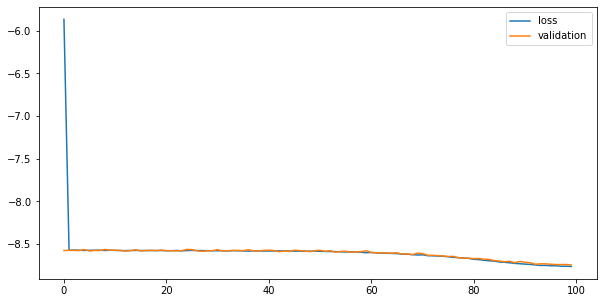

In [5]:
hist = sde_i.train_model(x_data, y_data, step_size=step_sizes,
                         validation_split=VALIDATION_SPLIT,
                         n_epochs=N_EPOCHS,
                         batch_size=BATCH_SIZE)

fig, hist_axes = plt.subplots(1, 1, figsize=(10, 5))
hist_axes.clear()
hist_axes.plot(hist.history["loss"], label='loss')
hist_axes.plot(hist.history["val_loss"], label='validation')
hist_axes.legend()

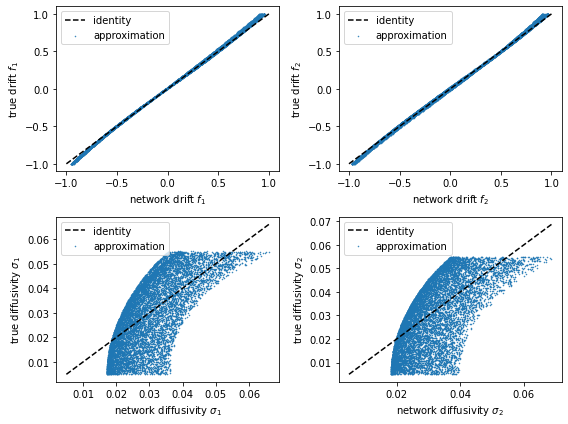

In [6]:
rng = np.random.default_rng(random_seed)

ax = plot_results_functions(sde_i.drift_diffusivity, true_drift_diffusivity,
                            x_data, y_data, rng,
                            data_transform_network=None,
                            data_transform_true=None)

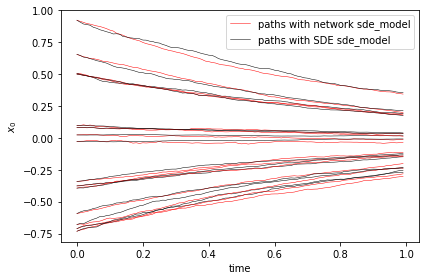

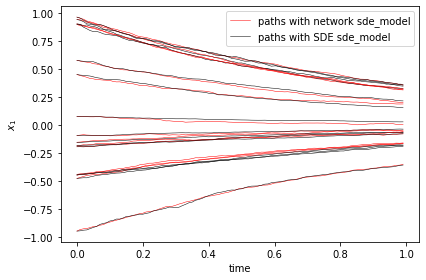

In [7]:
T_steps = 100
N_iterates = 15

rng = np.random.default_rng(random_seed)

time_steps, paths_network = \
    generate_results(sde_i.drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);
time_steps, paths_true = \
    generate_results(true_drift_diffusivity,
                     step_size, x_data, rng,
                     T_steps=T_steps, N_iterates=N_iterates);

plot_results_1d(time_steps, paths_network, paths_true, plot_dim=0, linewidth=.5);
plt.gca().set_ylabel(r"$x_0$");
plot_results_1d(time_steps, paths_network, paths_true, plot_dim=1, linewidth=.5);
plt.gca().set_ylabel(r"$x_1$");